In [1]:
import os
import sys
sys.path.append("../../NeuroGEN_Pytorch/")
from classes.VAE import VAE
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor
from torchvision.io import read_image
from torchsummary import summary

from torch import distributions as D
import wandb

from imutils import paths
import matplotlib.pyplot as plt
wandb.login()

import tqdm
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import classification_report

from sklearn.manifold import TSNE
from evaluations import *

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante (torvergatafmri). Use `wandb login --relogin` to force relogin


In [2]:
class decoder(nn.Module):

    def __init__(self, latent_dim=50,target_shape=(1,28,28) , n_conv=2, n_init_filters=64, condition_dim=10):

        super().__init__()

        self.condition_dim=condition_dim



        # infer the starting dimension.
        target_shape_side = target_shape[-1]



        self.startDim = target_shape_side // (2 ** n_conv)

        self.n_init_filters=n_init_filters
        
        #self.predecoder=nn.Unflatten(self.first_channels*self.startDim*self.startDim)
        self.predecoder=nn.Linear(latent_dim,self.n_init_filters*self.startDim*self.startDim)
        self.unflatten=nn.Unflatten(1,(self.n_init_filters,self.startDim,self.startDim))

        #self.condition =  nn.Linear(self.condition_dim,self.startDim*self.startDim)
        #self.condition2shape = nn.Unflatten(1, (1,self.startDim , self.startDim))
        feature_layers = []
        for i in range(n_conv):
            if i==0:
                feature_layers.append(nn.LazyConvTranspose2d(n_init_filters,kernel_size=4,stride=2,padding=1))
            else:
                feature_layers.append(nn.ConvTranspose2d(n_init_filters*(2**(i-1)),n_init_filters*2**i,kernel_size=4,stride=2,padding=1))

        self.features = nn.Sequential(*feature_layers)

        self.decoder_output=nn.LazyConvTranspose2d(target_shape[0],3,padding=1)
        self.activation=nn.Sigmoid()

    def forward(self,x):
        x = self.predecoder(x)
        x= self.unflatten(x)

#         c= self.condition(c)
#         c= self.condition2shape(c)
        
#         x= torch.concat((x,c),axis=1)
        x = x.view(x.shape[0], -1, self.startDim, self.startDim)
        x = self.features(x)
        x = self.decoder_output(x)
        x = self.activation(x)

        return x

In [3]:
encoder_architecture=[[0,64],[0,128],[0,256]]
decoder_architecture=[[0,64],[0,128]]

latent_dim=32
input_dim=(1,32,32)


config={"dataset":"MNIST", "type":"VAE","encoder_architecture":encoder_architecture,"decoder_architecture":decoder_architecture}
config["latent_dim"]=latent_dim
config["input_dim"]=input_dim

d=decoder(latent_dim=latent_dim,n_init_filters=128,target_shape=input_dim)


model=VAE(input_dim=input_dim,latent_dim=latent_dim,encoder_architecture=encoder_architecture,decoder_architecture=decoder_architecture)
model.decoder=d
#model=VAE(input_dim,latent_dim)

/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
# images_dir=r"C:\Users\matte\Dataset\tor_vergata\Dataset\Img\img_align_celeba"
#images_dir=r"/home/matteo/NeuroGEN/Dataset/Img/img_align_celeba"

#other important definitions

EPOCHS=20
BS=2000
INIT_LR=1e-4

config["epochs"]=EPOCHS
config["BS"]=BS
config["init_lr"]=INIT_LR


In [5]:
summary(model.encoder,(1,32,32),device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,088
      ConvResBlock-2           [-1, 64, 16, 16]               0
            Conv2d-3            [-1, 128, 8, 8]         131,200
      ConvResBlock-4            [-1, 128, 8, 8]               0
            Conv2d-5            [-1, 256, 4, 4]         524,544
      ConvResBlock-6            [-1, 256, 4, 4]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                   [-1, 32]         131,104
            Linear-9                   [-1, 32]         131,104
Total params: 919,040
Trainable params: 919,040
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 3.51
Estimated Total Size (MB): 3.98
-------------------------------------------

In [6]:
summary(model.decoder,(latent_dim,),device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]         270,336
         Unflatten-2            [-1, 128, 8, 8]               0
   ConvTranspose2d-3          [-1, 128, 16, 16]         262,272
   ConvTranspose2d-4          [-1, 256, 32, 32]         524,544
   ConvTranspose2d-5            [-1, 1, 32, 32]           2,305
           Sigmoid-6            [-1, 1, 32, 32]               0
Total params: 1,059,457
Trainable params: 1,059,457
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.39
Params size (MB): 4.04
Estimated Total Size (MB): 6.43
----------------------------------------------------------------


## Dataloaders

In [7]:
transform=Compose([Resize((32,32)),ToTensor()])

train_dataset=MNIST('mnist_train', train=True, download=True,
                             transform=transform)
test_dataset=MNIST('mnist_test', train=False, download=True,
                             transform=transform)


In [8]:
train_dataloader=DataLoader(train_dataset,batch_size=BS,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=BS,shuffle=True)


## Train Loop

In [9]:
base_path="models/vae_mnist_km"
os.makedirs(base_path,exist_ok=True)

In [10]:
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using {device} device")


Using cuda:0 device


In [11]:
#wandb.init(project="NeuroGEN_Pytorch",config=config)

In [12]:

#model.load_state_dict(torch.load(r"models/vae/model.ckp"))
train=True
optimizer=torch.optim.Adam(model.parameters(),lr=INIT_LR)

if train:
    model.fit(train_dataloader=train_dataloader,val_dataloader=test_dataloader,epochs=EPOCHS,optimizer=optimizer,device=device,wandb_log=False,save_model=base_path,early_stop=3)
    
else:
    model.load_state_dict(torch.load(os.path.join(base_path,"model.ckp")))

Epoch 0: 100%|█████| 30/30 [00:10<00:00,  2.74batch/s, kl_loss=0.00594, loss=0.0661, recon_loss=0.0602]
Val 0: 100%|█| 5/5 [00:01<00:00,  4.15batch/s, val_kl_loss=0.00594, val_loss=0.0672, val_recon_loss=0.0
Epoch 1: 100%|█████| 30/30 [00:10<00:00,  2.97batch/s, kl_loss=0.00785, loss=0.0533, recon_loss=0.0455]
Val 1: 100%|█| 5/5 [00:01<00:00,  4.14batch/s, val_kl_loss=0.00785, val_loss=0.0527, val_recon_loss=0.0
Epoch 2: 100%|██████| 30/30 [00:09<00:00,  3.11batch/s, kl_loss=0.0102, loss=0.0469, recon_loss=0.0366]
Val 2: 100%|█| 5/5 [00:01<00:00,  4.09batch/s, val_kl_loss=0.0102, val_loss=0.0473, val_recon_loss=0.03
Epoch 3: 100%|██████| 30/30 [00:10<00:00,  2.95batch/s, kl_loss=0.0115, loss=0.0438, recon_loss=0.0323]
Val 3: 100%|█| 5/5 [00:01<00:00,  3.99batch/s, val_kl_loss=0.0115, val_loss=0.0437, val_recon_loss=0.03
Epoch 4: 100%|██████| 30/30 [00:10<00:00,  2.84batch/s, kl_loss=0.0125, loss=0.0423, recon_loss=0.0298]
Val 4: 100%|█| 5/5 [00:01<00:00,  3.71batch/s, val_kl_loss=0.012

# BASELINE EVALUATION

In [13]:
cl_train=[]
y_train=[]
z_train=[]


cl_test=[]
y_test=[]
z_test=[]

with torch.no_grad():
    for x,y in tqdm.tqdm(train_dataloader):
        x=x.to(device)
        z_mu,z_sigma=model.encoder(x)
        dist=D.normal.Normal(z_mu, torch.exp(0.5 * z_sigma))
        z=dist.sample().cpu()
        
        z_train.append(z.numpy())
        y_train.append(y.numpy())
        
    for x,y in tqdm.tqdm(test_dataloader):
        x=x.to(device)
        z_mu,z_sigma=model.encoder(x)
        dist=D.normal.Normal(z_mu, torch.exp(0.5 * z_sigma))
        z=dist.sample().cpu()
        
        z_test.append(z.numpy())
        y_test.append(y.numpy())
        
    #cl_train=np.concatenate(cl_train,0)
    z_train=np.concatenate(z_train,0)
    y_train=np.concatenate(y_train,0)

    #cl_test=np.concatenate(cl_test,0)
    z_test=np.concatenate(z_test,0)
    y_test=np.concatenate(y_test,0)
        



100%|████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.03it/s]


## Looking for best kmeans K

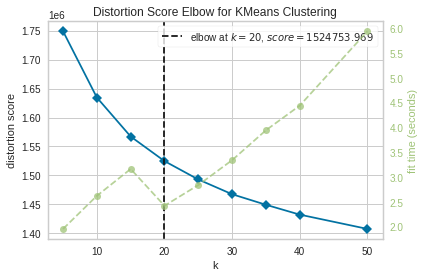

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
kmodel = KMeans()
visualizer = KElbowVisualizer(kmodel, k=[5,10,15,20,25,30,35,40,50])

visualizer.fit(z_train)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [15]:
n_clusters=visualizer.elbow_value_
kmodel=KMeans(n_clusters=n_clusters)
kmodel.fit(z_train)

cl_train=kmodel.predict(z_train)
cl_test=kmodel.predict(z_test)



In [16]:
config={"name":"VAEKMEANS","dataset":"MNIST","n_cluster":n_clusters}
wandb.init(project="VAESIM_CHARACT",config=config)

In [17]:
outputs=model_evaluation(z_train,y_train,z_test,y_test,cl_train,cl_test,device="cuda",n_cluster=n_clusters)
wandb.log(outputs)

[INFO] compute mappings and stat accuracy
{0: 7, 1: 8, 2: 3, 3: 9, 4: 0, 5: 4, 6: 8, 7: 5, 8: 6, 9: 0, 10: 1, 11: 0, 12: 2, 13: 7, 14: 5, 15: 4, 16: 2, 17: 1, 18: 6, 19: 3}
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       980
           1       0.81      0.93      0.87      1135
           2       0.85      0.69      0.76      1032
           3       0.65      0.72      0.69      1010
           4       0.46      0.55      0.50       982
           5       0.63      0.58      0.60       892
           6       0.80      0.86      0.83       958
           7       0.76      0.71      0.73      1028
           8       0.69      0.70      0.69       974
           9       0.52      0.37      0.43      1009

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000

[INFO] compute kNN accuracy


/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


              precision    recall  f1-score   support

           0       0.89      0.94      0.91       980
           1       0.77      0.97      0.86      1135
           2       0.86      0.81      0.83      1032
           3       0.77      0.81      0.79      1010
           4       0.73      0.73      0.73       982
           5       0.79      0.70      0.74       892
           6       0.87      0.91      0.89       958
           7       0.82      0.81      0.82      1028
           8       0.81      0.66      0.73       974
           9       0.72      0.67      0.69      1009

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

[INFO] compute linear accuracy


[LINEAR] epoch 9 loss: 0.8847764134407043 acc: 0.7708333730697632: 100%|█| 10/10 [00:06<00:00,  1.45it/


              precision    recall  f1-score   support

           0       0.86      0.86      0.86       980
           1       0.78      0.87      0.82      1135
           2       0.78      0.71      0.74      1032
           3       0.74      0.77      0.75      1010
           4       0.72      0.73      0.73       982
           5       0.67      0.61      0.64       892
           6       0.79      0.87      0.83       958
           7       0.79      0.80      0.79      1028
           8       0.70      0.68      0.69       974
           9       0.71      0.66      0.69      1009

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.75     10000
weighted avg       0.76      0.76      0.76     10000

